In [48]:
import numpy as np
import random as rd
import math

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import src.privacy_ml as ml #import split_horizontally, split_into_random_subsets, stepForward, stepForwardMono, stepForward_2
import src.logistic_reg as lr #import cost
import src.util as util

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
num_agents = 10
seed = 42

T = 500
mu = 0.05

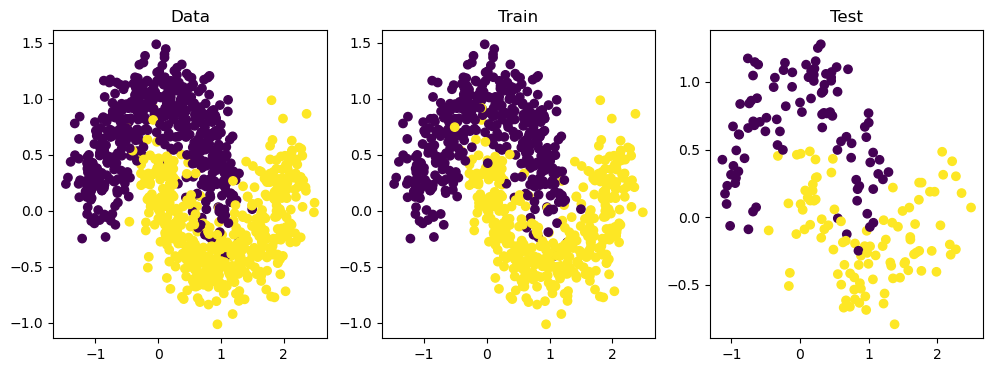

In [50]:
X, Y = make_moons(n_samples=1000, noise=0.2)


Y_formated = OneHotEncoder(categories='auto').fit_transform(Y.reshape(-1,1)).toarray()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=0.2)
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.scatter(X[:,0], X[:,1], c=Y)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train)
plt.title("Train")
plt.subplot(1, 3, 3)
plt.scatter(X_test[:,0], X_test[:,1], c=Y_test)
plt.title("Test")
plt.show()


On va trier les points par rapport à leur abscisse, pour simuler un effet de proximité entre les points, et utiliser cette proximité pour délimiter les différents agents.

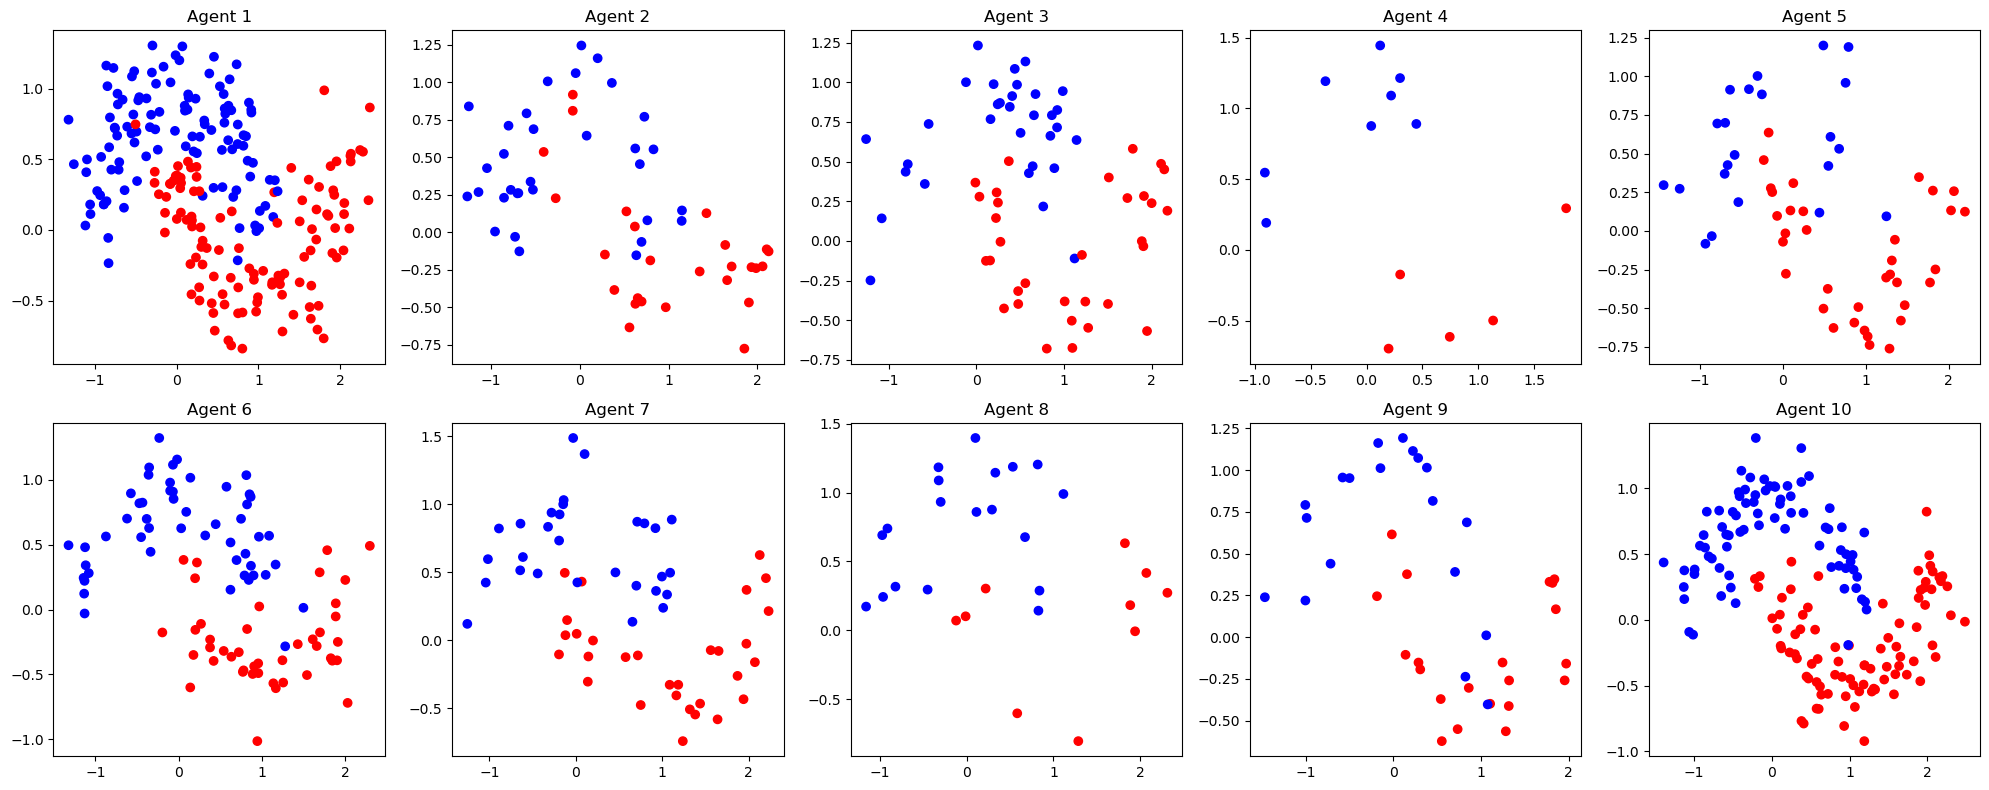

In [51]:

X_agent, Y_agent = ml.split_into_random_subsets(X_train, Y_train, random_state=seed)
#X_agent, Y_agent = ml.split_horizontally(X_train, Y_train)


fig, axes = plt.subplots(nrows=2, ncols=int(num_agents/2), figsize=(20, 8))

for i in range(num_agents):
    row = i // (num_agents // 2)
    col = i % (num_agents // 2)
    colors = ['blue' if y== 0 else 'red' for y in Y_agent[i]]
    axes[row, col].scatter(X_agent[i][:,0], X_agent[i][:,1], c=colors)
    axes[row, col].set_title(f'Agent {i+1}')

plt.tight_layout()
plt.show()

In [52]:
X_agent_augmented = []
for i in range(num_agents):
    X_agent_augmented.append(np.concatenate([X_agent[i], X_agent[i]**2, X_agent[i]**3, X_agent[i]**4, X_agent[i]**5], axis=1))

In [53]:
X_test_augmented = np.concatenate([X_test, X_test**2, X_test**3, X_test**4, X_test**5], axis=1)
X_train_augmented = np.concatenate([X_train, X_train**2, X_train**3, X_train**4, X_train**5], axis=1)

In [54]:
G = np.zeros((num_agents, num_agents))
for i in range(num_agents):
    for j in range(num_agents):
        if j == i+1 or j == i-1:
            G[i,j] = 1  
    
D = np.zeros(num_agents)
c = np.zeros(num_agents)

maxSize = np.max([x.shape[0] for x in X_agent])
print(f"Max: {maxSize}")
minSize = np.min([x.shape[0] for x in X_agent])
print(f"Min: {minSize}")
meanSize = np.mean([x.shape[0] for x in X_agent])
print(f"Mean: {meanSize}")
for i in range(num_agents):
    D[i] = np.sum(G[i,:])
    c[i] = X_agent[i].shape[0]/maxSize

print(f"G: {G}")
print(f"D: {D}")
print(f"c: {c}")

Max: 225
Min: 13
Mean: 80.0
G: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
D: [1. 2. 2. 2. 2. 2. 2. 2. 2. 1.]
c: [1.         0.25777778 0.28444444 0.05777778 0.25333333 0.41777778
 0.26222222 0.12888889 0.17777778 0.71555556]


## Logistic Regression and Gradient Descent


In linear regression, we got a real-valued response
	
$$\hat{y} = \theta_0 + \theta_1 x_1 + \cdots + \theta_d x_d,$$
    
i.e., a linear combination of inputs, where $\hat{y} \in \mathbf{R}$.

In classification, we want an *indication* of how likely an instance is to belong to a particular class; a probability $\in [0,1]$.  

Given a real valued $z$, we can squish it to range $\sigma(z) \in [0,1]$ by feeding it through the **logistic function** aka **sigmoid function**:
		
\begin{equation}
\sigma(z) = \frac{1}{1+\exp(-z)}. \hspace{1.5cm}(1)
\end{equation}

Which looks like this: ![Sigmoid](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/320px-Logistic-curve.svg.png)

Therefore, we can treat this as a probability, i.e.,

\begin{align*}
P(y=1|\mathbf{x}) &= \sigma(\mathbf{\theta}^\top\mathbf{x}), \\
P(y=0|\mathbf{x}) &= 1 - \sigma(\mathbf{\theta}^\top\mathbf{x}), 
\end{align*}

where we omit the bias term and suppose that both $\mathbf{\theta}$ and $\mathbf{x}$ are column vectors.

In order to chose values for the parameters of logistic regression, we use **maximum likelihood estimation** (MLE). As such we are going to have two steps:

1. write the likelihood function;
2. find the values of $\theta$ that maximize the log-likelihood function.


We begin by defining the design matrix $X \in \mathbb{R}^{n,d}$ containing our data points $x_i^T \in \mathbb{R}^{1\times d}$ on its rows and our column vector of model paramters $\theta \in \mathbb{R}^{d\times 1}.$
The labels that we are predicting are binary, this means that we can interpret each label as a Bernoulli random variable: $Y \sim Ber(p)$ where $p = \sigma(\mathbf{\theta}^\top\mathbf{x})$.

Therefore, we can write the probability of a data point as
$$
P\left(Y=y|X=\mathbf{x}\right) = \sigma(\mathbf{\theta}^\top\mathbf{x})^y \cdot \left[1-\sigma(\mathbf{\theta}^\top\mathbf{x})\right]^{(1-y)}.
$$

Given this probability mass function we can now write the **likelihood** of the whole dataset

\begin{equation}
L(\theta) = \prod_{i=1}^n P(Y = y_i|\mathbf{X} = \mathbf{x}_i) = \prod_{i=1}^n \sigma(\mathbf{\theta}^\top\mathbf{x}_i)^{y_i} \cdot \left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]^{(1-y_i)}. \hspace{1.5cm}(2)
\end{equation}

We can take the log of this function to transform the product into a sum and by doing that, we obtain the **log-likelihood**

\begin{equation}
LL(\theta) = \sum_{i=1}^n \left( y_i\log{\sigma(\mathbf{\theta}^\top\mathbf{x}_i)} + (1-y_i) \log{\left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]} \right). \hspace{1.5cm}(3)
\end{equation}

As you will remember from the first lab, our objective is to minimize the error by fitting our model to the data. However, the log-likelihood increases when the model is fitting better to the data. That's the reason why in logistic regression we take the *negative* log-likelihood (also known as **cost** function $E(\theta)$).

On a : $l(\theta) = - \sum_{i=1}^n \left( y_i\log{\sigma(\mathbf{\theta}^\top\mathbf{x}_i)} + (1-y_i) \log{\left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]} \right).$
donc la dérivée vaut : $\nabla _\theta l(\theta) = -\sum_{i=1}^n y_i (1-\sigma(\theta^Tx_i))x_i - (1-y_i) \sigma(\theta^Tx_i)x_i $

$ \nabla_\theta l(\theta) = -\sum_{i=1}^n (y_i - \sigma(\theta^Tx_i)) x_i $

Besoin du coeff de Lipschitz mais : https://proceedings.neurips.cc/paper_files/paper/2018/file/d54e99a6c03704e95e6965532dec148b-Paper.pdf

Supposons que le sigmoid soit L-lip
Alors 

$ \nabla_\theta l(\theta_0) - \nabla_\theta l(\theta_1)  = -\sum_{i=1}^n (\sigma(\theta_1^Tx_i) - \sigma(\theta_0^Tx_i)) x_i$

$| \nabla_\theta l(\theta_0) - \nabla_\theta l(\theta_1) |_2 \leq \sum_{i=1}^n L|(\theta_1^T - \theta_0^T)x_i| | x_i |_2  \leq \sum_{i=1}^n L|\theta_1^T - \theta_0|_2 |x_i|_2 | x_i |_2 $

Or on a $L = \frac{1}{4} $


## Training

### Single Global Model

In [55]:
np.random.seed(seed)
thetas_mono = np.random.rand(X_train_augmented.shape[1])
costs_train_mono = np.zeros((T))
costs_test_mono = np.zeros((T))

train_acc = np.zeros((T))
test_acc = np.zeros((T))

for i in range(T):
    thetas_mono = ml.stepForwardMono(thetas_mono, X_train_augmented, Y_train)
    costs_train_mono[i] = lr.cost(thetas_mono, X_train_augmented, Y_train)
    costs_test_mono[i] = lr.cost(thetas_mono, X_test_augmented, Y_test)

    train_acc[i] = lr.accuracy(thetas_mono, X_train_augmented, Y_train)
    test_acc[i] = lr.accuracy(thetas_mono, X_test_augmented, Y_test)

    if i % (T/10) == 0:
                print(f'Iteration {i} : Train: {costs_train_mono[i]:.4f} | Test: {costs_test_mono[i]:.4f}')

# np.random.seed(seed)
# thetas_agents_globalModel = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

# costs_train_agents_globalModel = np.zeros((T, num_agents))
# costs_test_agents_globalModel = np.zeros((T, num_agents))

# print(T)
# for i in range(T):
#     thetas_agents_globalModel = ml.stepForward(thetas_agents_globalModel, X_agent_augmented, Y_agent, num_agents, 0, c, G, D)
#     for j in range(num_agents):
#             costs_train_agents_globalModel[i,j] = lr.cost(thetas_agents_globalModel[j], X_agent_augmented[j], Y_agent[j])
#             costs_test_agents_globalModel[i,j] = lr.cost(thetas_agents_globalModel[j], X_test_augmented, Y_test)
#     if i % 1000 == 0 :
#         print(f'Iteration {i+1} : Train: {np.mean(costs_train_agents_globalModel[i]):.4f} and {np.std(costs_train_agents_globalModel[i]):.4f} | Test: {np.mean(costs_test_agents_globalModel[i]):.4f} and {np.std(costs_test_agents_globalModel[i]):.4f}')

Iteration 0 : Train: 1.3508 | Test: 1.3829
Iteration 50 : Train: 1.0547 | Test: 1.0748
Iteration 100 : Train: 0.8014 | Test: 0.8163
Iteration 150 : Train: 0.6178 | Test: 0.6318
Iteration 200 : Train: 0.5123 | Test: 0.5260
Iteration 250 : Train: 0.4563 | Test: 0.4688
Iteration 300 : Train: 0.4225 | Test: 0.4342
Iteration 350 : Train: 0.3995 | Test: 0.4106
Iteration 400 : Train: 0.3823 | Test: 0.3932
Iteration 450 : Train: 0.3689 | Test: 0.3796


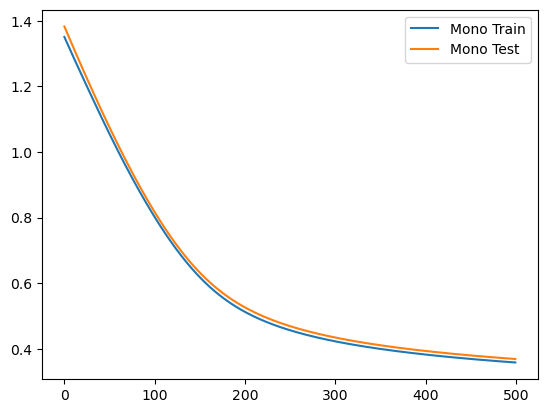

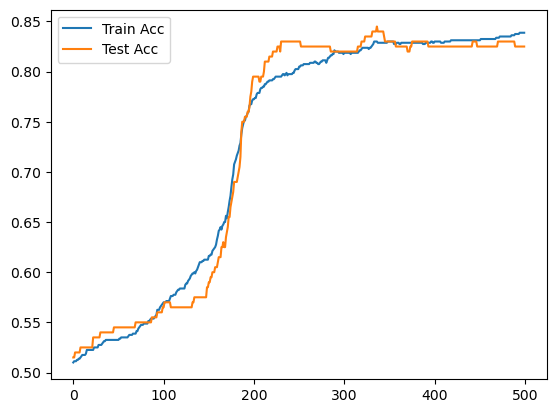

In [56]:
plt.plot(costs_train_mono, label="Mono Train")
plt.plot(costs_test_mono, label="Mono Test")
plt.legend()
plt.show()

plt.plot(train_acc, label="Train Acc")
plt.plot(test_acc, label="Test Acc")
plt.legend()
plt.show()

# util.plot_curves(num_agents, costs_train_agents_globalModel, costs_test_agents_globalModel, "Multiple Agents")

### Multiple agents

Agents dont share their models (perfectly private baseline)

In [57]:
np.random.seed(seed)
thetas_agents_alone = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

costs_train_agents_alone = np.zeros((T, num_agents))
costs_test_agents_alone = np.zeros((T, num_agents))
costs_train_alone = np.zeros(T)
costs_test_alone = np.zeros(T)
acc_train_agents_alone = np.zeros((T, num_agents))
acc_test_agents_alone = np.zeros((T, num_agents))

print("Iter: Agents_Mean       | Total ")
for i in range(T):
    thetas_agents_alone = ml.stepForwardAlone(thetas_agents_alone, X_agent_augmented, Y_agent, num_agents, mu, c, G, D)
    for j in range(num_agents):
            costs_train_agents_alone[i,j] = lr.cost(thetas_agents_alone[j], X_agent_augmented[j], Y_agent[j])
            costs_test_agents_alone[i,j] = lr.cost(thetas_agents_alone[j], X_test_augmented, Y_test)

            acc_train_agents_alone[i, j] = lr.accuracy(thetas_agents_alone[j], X_agent_augmented[j], Y_agent[j])
            acc_test_agents_alone[i, j] = lr.accuracy(thetas_agents_alone[j], X_test_augmented, Y_test)

    costs_train_alone[i] = lr.costDecentralized(thetas_agents_alone, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
    costs_test_alone[i] = lr.costDecentralized(thetas_agents_alone, X_test_augmented, Y_test, num_agents, G, D, c, mu)

    if i % (T/10) == 0 :
        print(f'{i:3} : ({np.mean(costs_train_agents_alone[i]):.4f} , {np.mean(costs_test_agents_alone[i]):.4f}) | ({costs_train_alone[i]:.4f} , {costs_test_alone[i]:.4f})')

Iter: Agents_Mean       | Total 
  0 : (1.2444 , 1.1792) | (8.3014 , 8.0109)
 50 : (0.7939 , 0.8549) | (10.2760 , 10.0655)
100 : (0.6099 , 0.6740) | (10.3126 , 10.1500)
150 : (0.4984 , 0.5620) | (10.1086 , 9.9754)
200 : (0.4303 , 0.4951) | (9.9739 , 9.8586)
250 : (0.3898 , 0.4553) | (9.9920 , 9.8876)
300 : (0.3638 , 0.4299) | (10.1018 , 10.0047)
350 : (0.3455 , 0.4123) | (10.2538 , 10.1619)
400 : (0.3315 , 0.3992) | (10.4319 , 10.3438)
450 : (0.3204 , 0.3890) | (10.6284 , 10.5435)


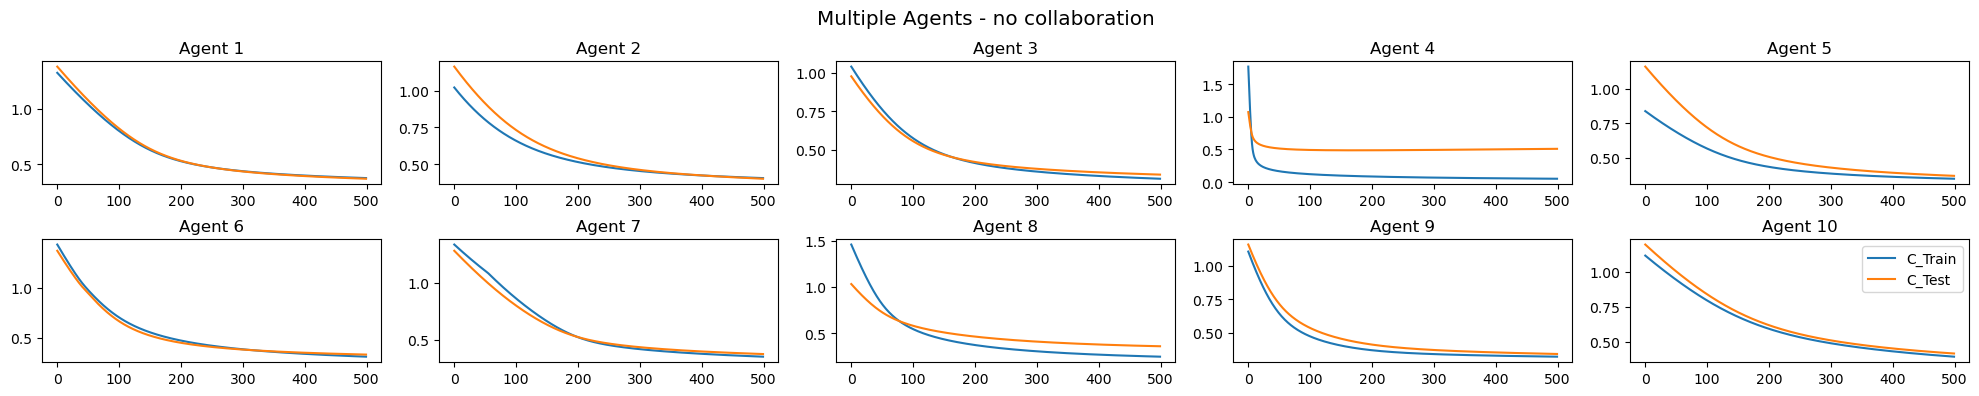

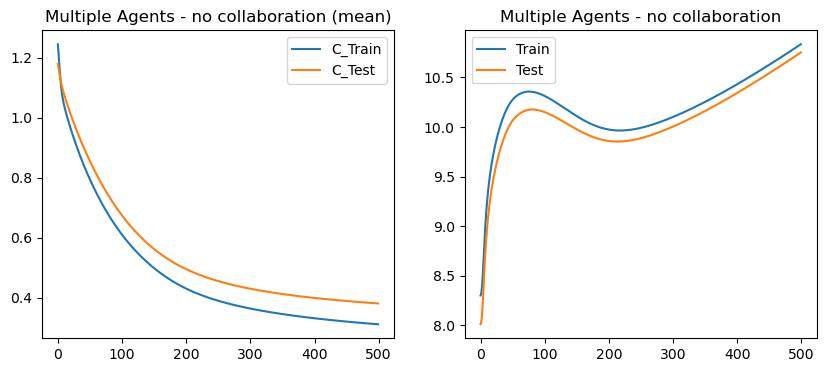

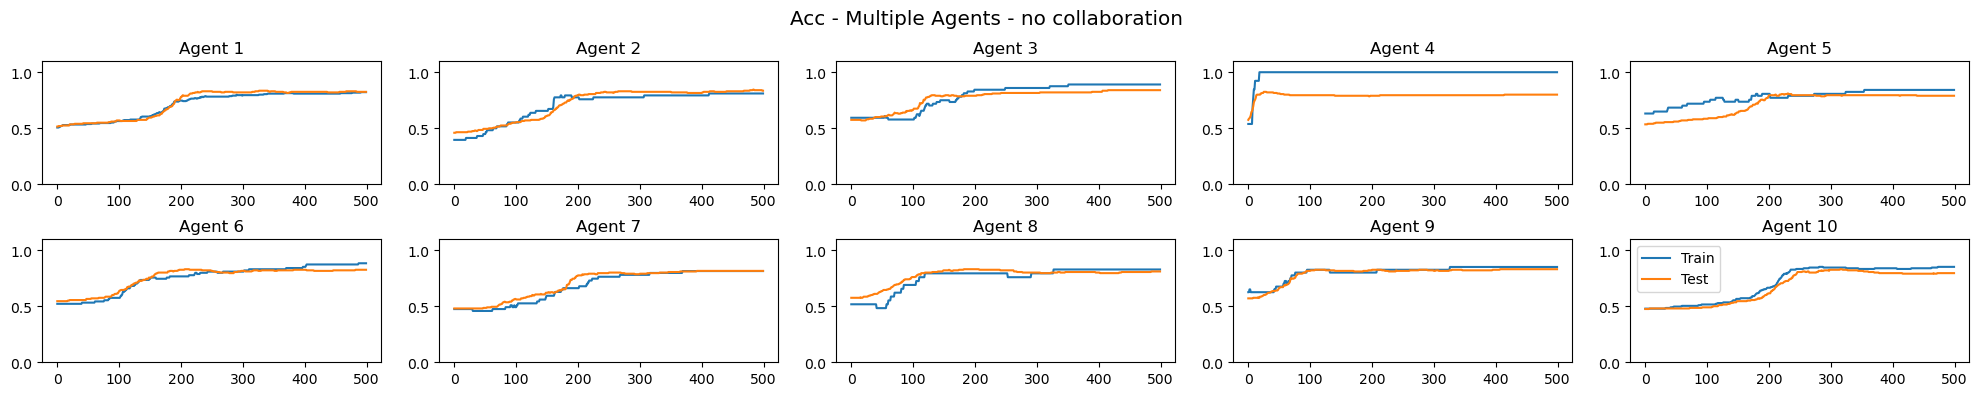

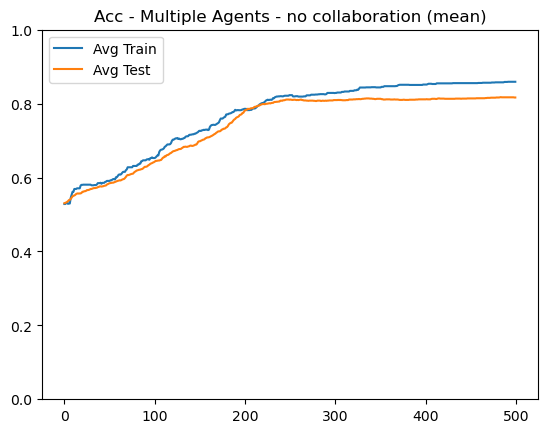

In [59]:
util.plot_curves(num_agents, costs_train_agents_alone, costs_test_agents_alone, costs_train_alone, costs_test_alone, "Multiple Agents - no collaboration")
util.plot_accuracy(num_agents, acc_train_agents_alone, acc_test_agents_alone, "Acc - Multiple Agents - no collaboration")

### Multiple agents

All agents do a step after each other in a naive queue and share their models

In [60]:
np.random.seed(seed)
thetas_agents = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

costs_train_agents = np.zeros((T, num_agents))
costs_test_agents = np.zeros((T, num_agents))
costs_train = np.zeros(T)
costs_test = np.zeros(T)
acc_train_agents = np.zeros((T, num_agents))
acc_test_agents = np.zeros((T, num_agents))

print("Iter: Agents_Mean       | Total ")
for i in range(T):
    thetas_agents = ml.stepForward(thetas_agents, X_agent_augmented, Y_agent, num_agents, mu, c, G, D)
    for j in range(num_agents):
            costs_train_agents[i,j] = lr.cost(thetas_agents[j], X_agent_augmented[j], Y_agent[j])
            costs_test_agents[i,j] = lr.cost(thetas_agents[j], X_test_augmented, Y_test)

            acc_train_agents[i,j] = lr.accuracy(thetas_agents[j], X_agent_augmented[j], Y_agent[j])
            acc_test_agents[i,j] = lr.accuracy(thetas_agents[j], X_test_augmented, Y_test)
    costs_train[i] = lr.costDecentralized(thetas_agents, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
    costs_test[i] = lr.costDecentralized(thetas_agents, X_test_augmented, Y_test, num_agents, G, D, c, mu)
    if i % (T/10) == 0 :
        print(f'{i:3} : ({np.mean(costs_train_agents[i]):.4f} , {np.mean(costs_test_agents[i]):.4f}) | ({costs_train[i]:.4f} , {costs_test[i]:.4f})')

Iter: Agents_Mean       | Total 
  0 : (1.2557 , 1.1790) | (6.8205 , 6.5291)
 50 : (0.9424 , 0.9103) | (0.9054 , 0.6812)
100 : (0.6960 , 0.7040) | (0.5289 , 0.3568)
150 : (0.5497 , 0.5746) | (0.3932 , 0.2541)
200 : (0.4724 , 0.5011) | (0.3238 , 0.2035)
250 : (0.4267 , 0.4565) | (0.2815 , 0.1727)
300 : (0.3966 , 0.4270) | (0.2534 , 0.1521)
350 : (0.3751 , 0.4058) | (0.2330 , 0.1372)
400 : (0.3588 , 0.3897) | (0.2173 , 0.1256)
450 : (0.3460 , 0.3770) | (0.2045 , 0.1162)


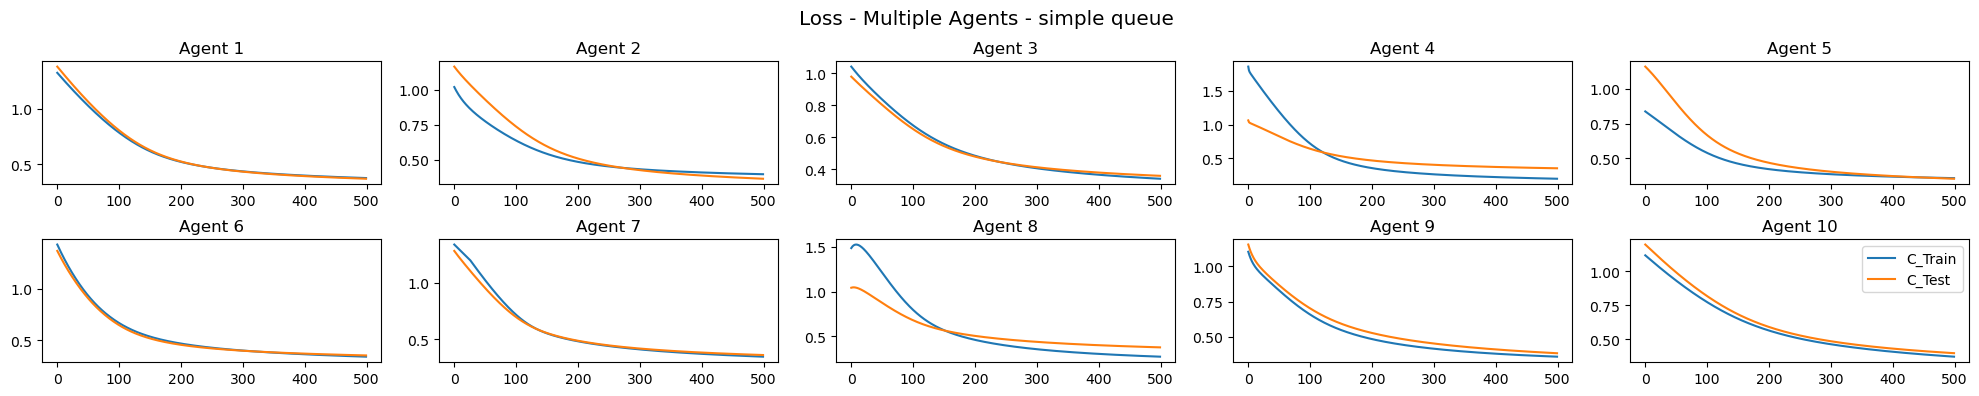

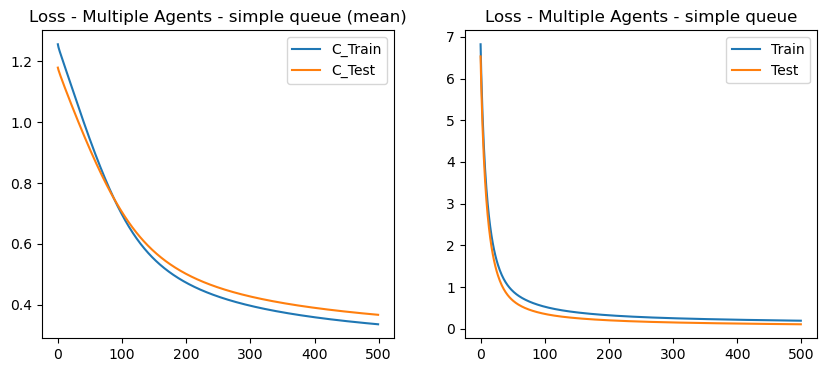

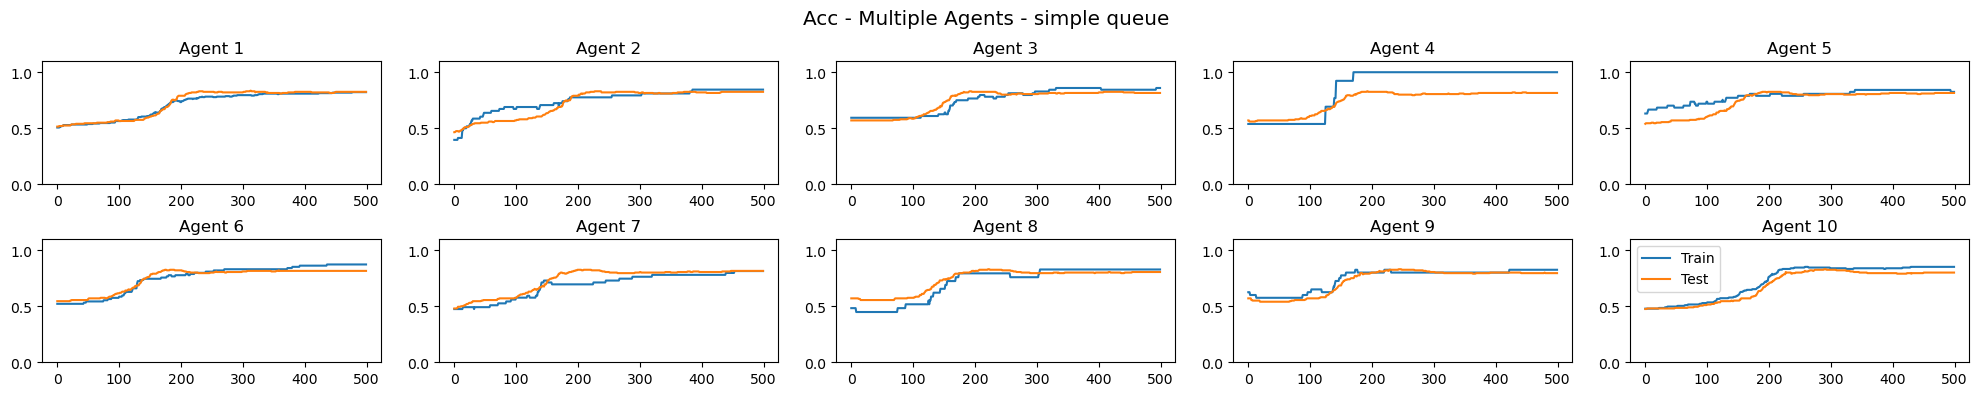

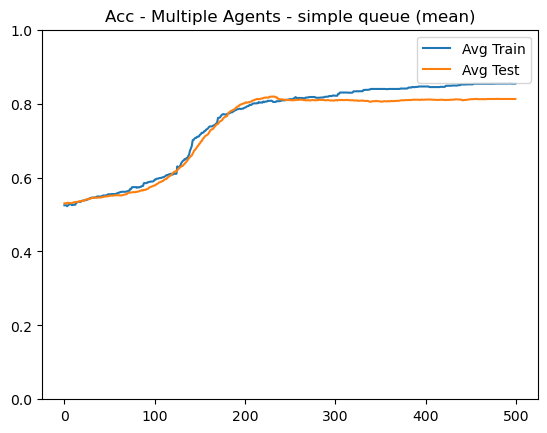

In [61]:
util.plot_curves(num_agents, costs_train_agents, costs_test_agents, costs_train, costs_test, "Loss - Multiple Agents - simple queue")
util.plot_accuracy(num_agents, acc_train_agents, acc_test_agents, "Acc - Multiple Agents - simple queue")

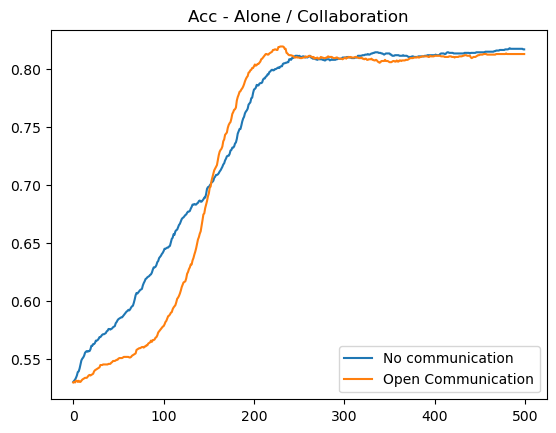

In [66]:
plt.plot(np.mean(acc_test_agents_alone, axis=1), label="No communication")
plt.plot(np.mean(acc_test_agents, axis=1), label="Open Communication")
plt.legend()
plt.title("Acc - Alone / Collaboration")
plt.show()

### Random drawing of Agents

randint with global quota

In [152]:
np.random.seed(seed)
tracking  = np.zeros(num_agents) # pour mesurer le nombre de fois que chaque agent passe
total_T = T*num_agents

thetas_agents_rand = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_rand = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_rand = np.zeros((total_T, num_agents))
costs_test_rand = np.zeros(total_T)
costs_train_rand = np.zeros(total_T)


print("Iter: Agents_Mean       | Total ")
for i in range (total_T) :
    j = rd.randint(0, num_agents-1)
    tracking[j] += 1

    thetas_agents_rand = ml.stepForward_2(thetas_agents_rand, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D) 

    costs_train_agents_rand[i, j] = lr.cost(thetas_agents_rand[j], X_agent_augmented[j], Y_agent[j])
    costs_test_agents_rand[i, j] = lr.cost(thetas_agents_rand[j], X_test_augmented, Y_test)

    if i % 10 == 0:
        costs_train_rand[int(i/10)] = lr.costDecentralized(thetas_agents_rand, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_rand[int(i/10)] = lr.costDecentralized(thetas_agents_rand, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_rand[i]):.4f} , {np.mean(costs_test_agents_rand[i]):.4f}) | ({costs_train_rand[int(i/10)]:.4f} , {costs_test_rand[int(i/10)]:.4f})')

costs_train_agents_rand = util.reduce_cost_matrix(costs_train_agents_rand)
costs_test_agents_rand = util.reduce_cost_matrix(costs_test_agents_rand)
costs_train_rand = costs_train_rand[:T]
costs_test_rand = costs_test_rand[:T]

Iter: Agents_Mean       | Total 
  0 : (0.1863 , 0.1065) | (7.5402 , 7.2475)
 50 : (0.1276 , 0.0862) | (0.9685 , 0.7399)
100 : (0.0721 , 0.0760) | (0.5677 , 0.3899)
150 : (0.0579 , 0.0561) | (0.3909 , 0.2490)
200 : (0.0438 , 0.0499) | (0.3172 , 0.1954)
250 : (0.0454 , 0.0462) | (0.2753 , 0.1653)
300 : (0.0431 , 0.0428) | (0.2413 , 0.1393)
350 : (0.0419 , 0.0405) | (0.2191 , 0.1228)
400 : (0.0303 , 0.0399) | (0.2094 , 0.1174)
450 : (0.0386 , 0.0410) | (0.1978 , 0.1091)


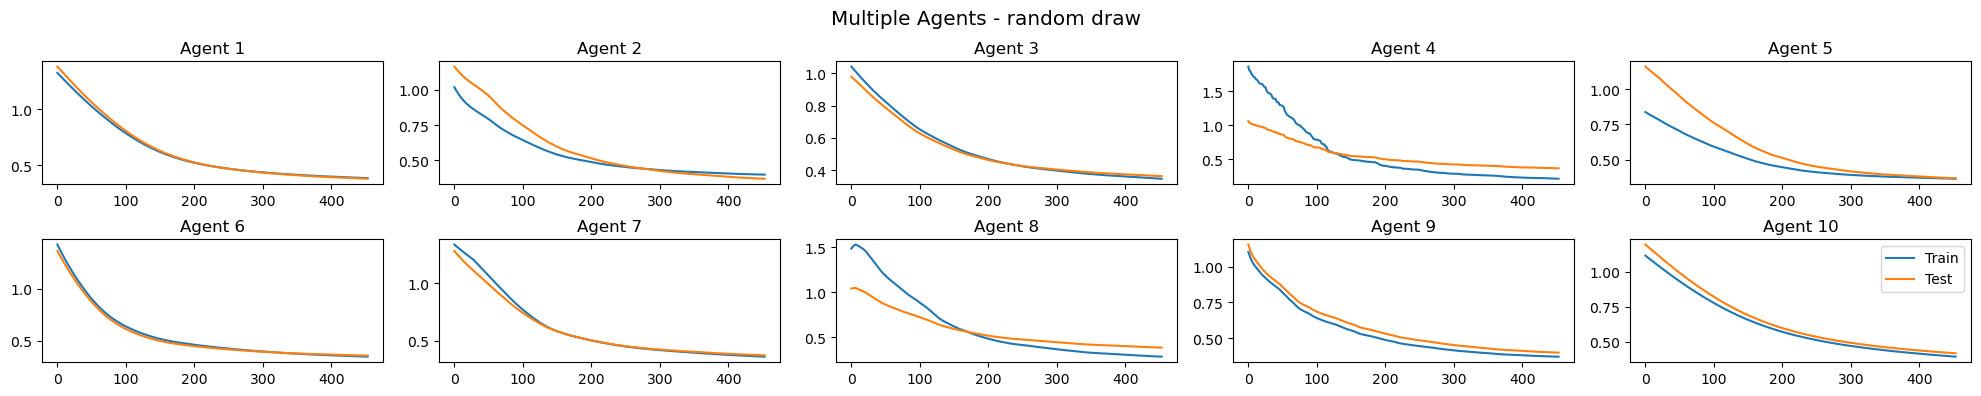

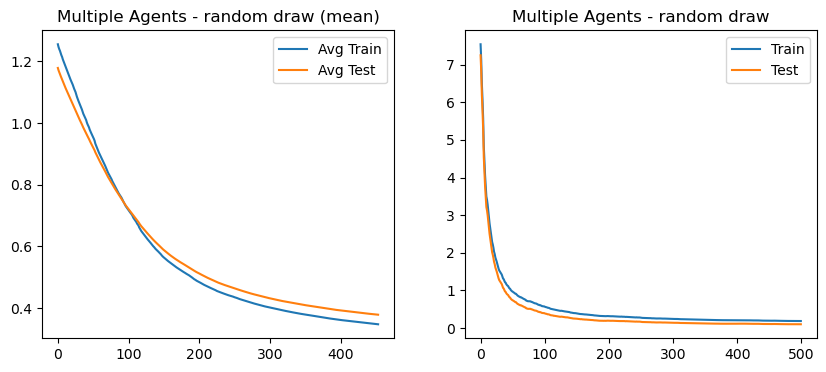

In [153]:
util.plot_curves(num_agents, costs_train_agents_rand, costs_test_agents_rand, costs_train_rand, costs_test_rand, "Multiple Agents - random draw")

### Weighting of Agents

In [154]:
np.random.seed(seed)
tracking  = np.zeros(num_agents)
total_T = T*num_agents

thetas_agents_weigh = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_weigh = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_weigh = np.zeros((total_T, num_agents))
costs_test_weigh = np.zeros(total_T)
costs_train_weigh = np.zeros(total_T)


# on obtient les probabilités qu'on veut pour chaque modèle à chaque tirage
coeffs_pond = np.zeros(num_agents)
c_tot = 0
for i in range (len(c)) :
    c_tot += c[i]    
for i in range (len(c)) :
    coeffs_pond[i] = c[i]/c_tot
    
print(coeffs_pond)
print("Iter: Agents_Mean       | Total ")

for i in range(total_T) :
    j = np.random.choice(10, 1, p=coeffs_pond)[0]
    tracking[j] += 1

    thetas_agents_weigh = ml.stepForward_2(thetas_agents_weigh, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D) 

    costs_train_agents_weigh[i, j] = (lr.cost(thetas_agents_weigh[j], X_agent_augmented[j], Y_agent[j]))
    costs_test_agents_weigh[i, j] = (lr.cost(thetas_agents_weigh[j], X_test_augmented, Y_test))

    if i % 10 == 0:
        costs_train_weigh[int(i/10)] = lr.costDecentralized(thetas_agents_weigh, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_weigh[int(i/10)] = lr.costDecentralized(thetas_agents_weigh, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_weigh[i]):.4f} , {np.mean(costs_test_agents_weigh[i]):.4f}) | ({costs_train_weigh[int(i/10)]:.4f} , {costs_test_weigh[int(i/10)]:.4f})')

# costs_train_agents_weigh = util.reduce_cost_matrix(costs_train_agents_weigh)
# costs_test_agents_weigh = util.reduce_cost_matrix(costs_test_agents_weigh)

costs_train_agents_weigh_shifted = util.shift_non_zero_costs_to_front(costs_train_agents_weigh)
costs_test_agents_weigh_shifted = util.shift_non_zero_costs_to_front(costs_test_agents_weigh)

non_zero_counts = np.count_nonzero(costs_train_agents_weigh_shifted, axis=0)    
max_non_zero = np.max(non_zero_counts)
costs_train_weigh = costs_train_weigh[:max_non_zero]
costs_test_weigh = costs_test_weigh[:max_non_zero]


[0.28125 0.0725  0.08    0.01625 0.07125 0.1175  0.07375 0.03625 0.05
 0.20125]
Iter: Agents_Mean       | Total 
  0 : (0.1327 , 0.1383) | (8.3138 , 8.0208)
 50 : (0.0673 , 0.0686) | (1.3376 , 1.1310)
100 : (0.0464 , 0.0463) | (0.8608 , 0.7041)
150 : (0.0412 , 0.0408) | (0.6121 , 0.4842)
200 : (0.0435 , 0.0459) | (0.4474 , 0.3369)
250 : (0.0430 , 0.0425) | (0.3567 , 0.2562)
300 : (0.0357 , 0.0350) | (0.2885 , 0.1946)
350 : (0.0347 , 0.0340) | (0.2675 , 0.1782)
400 : (0.0368 , 0.0374) | (0.2519 , 0.1661)
450 : (0.0334 , 0.0325) | (0.2330 , 0.1500)


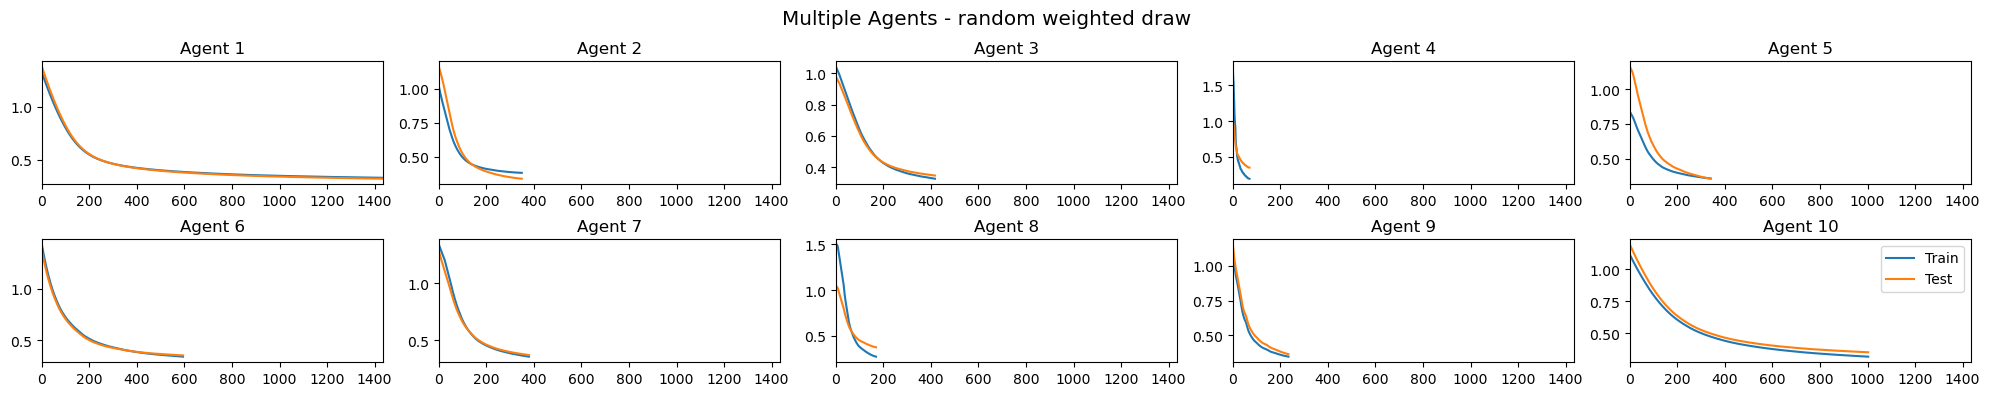

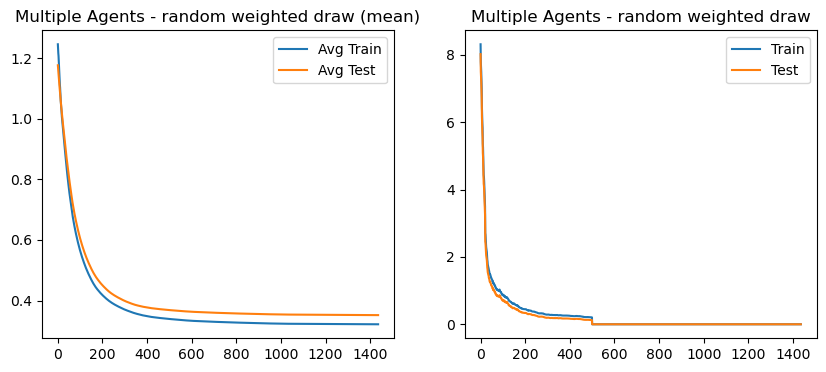

In [155]:
util.plot_curves_non_zero(num_agents, costs_train_agents_weigh_shifted, costs_test_agents_weigh_shifted, costs_train_weigh, costs_test_weigh, "Multiple Agents - random weighted draw")

## With Privacy

On fait avec $\delta = 0$ et $\epsilon_i(t_i) = \epsilon$

Si on veut partir du $\bar{\epsilon}$, on va utiliser $\delta$ et $\bar{\delta}$ tous nuls, et utiliser le théorème 1 (et la proposition 2 dans un deuxième temps) pour obtenir des epsilon.

Ici on peut avoir des $\bar{\epsilon}$ très élevés


In [156]:
epsilon = 0.5 # -> ici on a donc epsilon_barre = epsilon * T = 500
L_0 = 0.25



np.random.seed(seed)
thetas_private = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

costs_train_private = np.zeros(T)
costs_test_private = np.zeros(T)

for i in range(T):
    thetas_private = ml.stepForwardPrivate(thetas_private, X_agent_augmented, Y_agent, num_agents, mu, c, G, D, L_0, epsilon)
    costs_train_private[i] = lr.costDecentralized(thetas_private, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
    costs_test_private[i] = lr.costDecentralized(thetas_private, X_test_augmented, Y_test, num_agents, G, D, c, mu)
    if i % (T/10) == 0 :
        print(f'Iteration {i} : Train: {costs_train_private[i]:.4f} | Test: {costs_test_private[i]:.4f}')

Iteration 0 : Train: 6.9259 | Test: 6.6341
Iteration 50 : Train: 0.9829 | Test: 0.7587
Iteration 100 : Train: 0.6262 | Test: 0.4551
Iteration 150 : Train: 0.4936 | Test: 0.3544
Iteration 200 : Train: 0.3952 | Test: 0.2750
Iteration 250 : Train: 0.3325 | Test: 0.2232
Iteration 300 : Train: 0.3602 | Test: 0.2590
Iteration 350 : Train: 0.3164 | Test: 0.2204
Iteration 400 : Train: 0.2864 | Test: 0.1945
Iteration 450 : Train: 0.2622 | Test: 0.1739


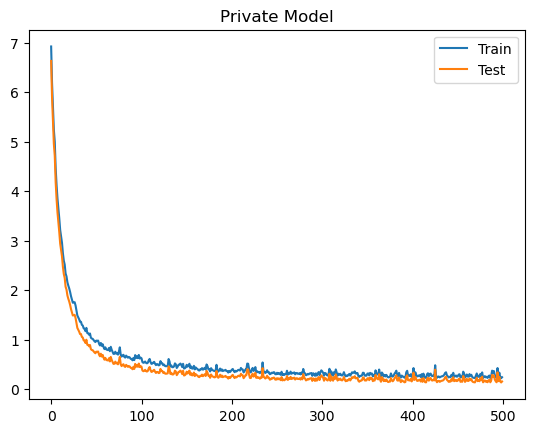

In [157]:
plt.plot(costs_train_private, label="Train")
plt.plot(costs_test_private, label="Test")
plt.title("Private Model")
plt.legend()
plt.show()

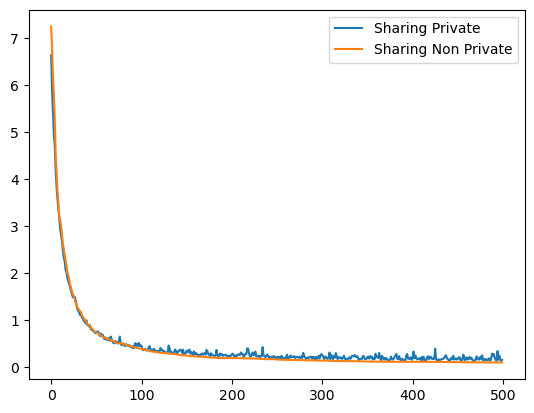

In [158]:
plt.plot(costs_test_private, label="Sharing Private")
#plt.plot(costs_test_alone, label="No Sharing")
plt.plot(costs_test_rand, label="Sharing Non Private")
plt.legend()
plt.show()

### Random drawing using constant epsilon

In [ ]:
# epsilon = epsilon_barre / T # pour stepForwardPrivate normal

# il faut réestimer le epsilon_barre lorsque le nombre d'étapes d'entraînement pour un modèle n'est pas exactement T 

epsilon_barre = 50

epsilon = epsilon_barre / T

np.random.seed(seed)
tracking  = np.zeros(num_agents) # pour mesurer le nombre de fois que chaque agent passe
total_T = T*num_agents

thetas_agents_private_rand = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_private_rand = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_private_rand = np.zeros((total_T, num_agents))
costs_test_private_rand = np.zeros(total_T)
costs_train_private_rand = np.zeros(total_T)


print("Iter: Agents_Mean       | Total ")
for i in range (total_T) :
    j = rd.randint(0, num_agents-1)
    tracking[j] += 1

    thetas_agents_private_rand = ml.stepForwardPrivate_2(thetas_agents_private_rand, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D, epsilon) 

    costs_train_agents_private_rand[i, j] = lr.cost(thetas_agents_private_rand[j], X_agent_augmented[j], Y_agent[j])
    costs_test_agents_private_rand[i, j] = lr.cost(thetas_agents_private_rand[j], X_test_augmented, Y_test)

    if i % 10 == 0:
        costs_train_private_rand[int(i/10)] = lr.costDecentralized(thetas_agents_private_rand, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_private_rand[int(i/10)] = lr.costDecentralized(thetas_agents_private_rand, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_private_rand[i]):.4f} , {np.mean(costs_test_agents_private_rand[i]):.4f}) | ({costs_train_private_rand[int(i/10)]:.4f} , {costs_test_private_rand[int(i/10)]:.4f})')

costs_train_agents_private_rand = util.reduce_cost_matrix(costs_train_agents_private_rand)
costs_test_agents_private_rand = util.reduce_cost_matrix(costs_test_agents_private_rand)
costs_train_private_rand = costs_train_private_rand[:T]
costs_test_private_rand = costs_test_private_rand[:T]

In [ ]:
plt.plot(costs_train_private_rand, label="Train")
plt.plot(costs_test_private_rand, label="Test")
plt.title("Private Model")
plt.legend()
plt.show()

### Weighted drawing with constant epsilons

In [ ]:
# DEFINING EPSILON_BAR
epsilon_barre = 50

np.random.seed(seed)
tracking  = np.zeros(num_agents)
total_T = T*num_agents

thetas_agents_private_weigh = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_private_weigh = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_private_weigh = np.zeros((total_T, num_agents))
costs_test_private_weigh = np.zeros(total_T)
costs_train_private_weigh = np.zeros(total_T)


# on obtient les probabilités qu'on veut pour chaque modèle à chaque tirage
coeffs_pond = np.zeros(num_agents)
c_tot = 0
for i in range (len(c)) :
    c_tot += c[i]    
for i in range (len(c)) :
    coeffs_pond[i] = c[i]/c_tot
    
# des probabilités, on déduit l'espérance du nombre d'itérations pour chaque agent
nb_iterations = np.zeros(num_agents)
for i in range (num_agents):
    nb_iterations = c * total_T

# puis les epsilon correspondants pour chaque agent
epsilon = np.zeros(num_agents)

for i in range(num_agents): 
    epsilon[i] = epsilon_barre / nb_iterations[i]
    

print("Iter: Agents_Mean       | Total ")

for i in range(total_T) :
    j = np.random.choice(10, 1, p=coeffs_pond)[0]
    tracking[j] += 1

    thetas_agents_private_weigh = ml.stepForwardPrivate_2(thetas_agents_private_rand, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D, epsilon[0])

    costs_train_agents_private_weigh[i, j] = (lr.cost(thetas_agents_private_weigh[j], X_agent_augmented[j], Y_agent[j]))
    costs_test_agents_private_weigh[i, j] = (lr.cost(thetas_agents_private_weigh[j], X_test_augmented, Y_test))

    if i % 10 == 0:
        costs_train_private_weigh[int(i/10)] = lr.costDecentralized(thetas_agents_private_weigh, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_private_weigh[int(i/10)] = lr.costDecentralized(thetas_agents_private_weigh, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_private_weigh[i]):.4f} , {np.mean(costs_test_agents_private_weigh[i]):.4f}) | ({costs_train_weigh[int(i/10)]:.4f} , {costs_test_weigh[int(i/10)]:.4f})')

# costs_train_agents_weigh = util.reduce_cost_matrix(costs_train_agents_weigh)
# costs_test_agents_weigh = util.reduce_cost_matrix(costs_test_agents_weigh)

costs_train_agents_private_weigh_shifted = util.shift_non_zero_costs_to_front(costs_train_agents_weigh)
costs_test_agents_private_weigh_shifted = util.shift_non_zero_costs_to_front(costs_test_agents_weigh)

non_zero_counts = np.count_nonzero(costs_train_agents_private_weigh_shifted, axis=0)    
max_non_zero = np.max(non_zero_counts)
costs_train_private_weigh = costs_train_private_weigh[:max_non_zero]
costs_test_private_weigh = costs_test_private_weigh[:max_non_zero]


### Weighted epsilons  implementing theorem 2 : optimal choice of epsilon

In [ ]:

np.random.seed(seed)
tracking  = np.zeros(num_agents)
total_T = T*num_agents

thetas_agents_private_weigh = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_private_weigh = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_private_weigh = np.zeros((total_T, num_agents))
costs_test_private_weigh = np.zeros(total_T)
costs_train_private_weigh = np.zeros(total_T)



# on obtient les probabilités qu'on veut pour chaque modèle à chaque tirage
coeffs_pond = np.zeros(num_agents)
c_tot = 0
for i in range (len(c)) :
    c_tot += c[i]    
for i in range (len(c)) :
    coeffs_pond[i] = c[i]/c_tot
    
# on doit calculer grand C = 1 - sigma /(n*Lmax)
# sigma - strongly convex  : correspond à Ql
# Lmax : max Li, les Li sont les constantesblock lipschitz du gradient de Ql
sigma = 0.5                                                                                        # randomly chosen at the moment
Lmax = 1

big_c = 1 - sigma/(num_agents*Lmax)
cube = math.cbrt(big_c)
lambdas = np.zeros(num_agents)
agent_choice = np.zeros(total_T)

# we have to know in advance at which iterations each machine wakes up
for i in range(total_T) :
    j = np.random.choice(10, 1, p=coeffs_pond)[0]
    agent_choice[i] = j
    
agents_pre_epsilon = np.zeros(total_T)
    
# now let's compute our lambdas
for i in range (total_T):
    res = ((cube-1) / (pow(cube, total_T)-1)) * pow(cube, i)
    agents_pre_epsilon[i] = res
    lambdas[agent_choice[i]] += res

# we fix our epsilon_bar
epsilon_bar = 50

# now let's compute our epsilons
epsilons = np.zeros(total_T)
for i in range (total_T):
    epsilons[i] = agents_pre_epsilon[i] * epsilon_bar / lambdas[agent_choice[i]]
    

    
print(coeffs_pond)
print("Iter: Agents_Mean       | Total ")

for i in range(total_T) :
    j = agent_choice[i]
    epsilon = epsilons[i]
    thetas_agents_private_weigh = ml.stepForwardPrivate_2(thetas_agents_private_rand, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D, epsilon)

    costs_train_agents_private_weigh[i, j] = (lr.cost(thetas_agents_private_weigh[j], X_agent_augmented[j], Y_agent[j]))
    costs_test_agents_private_weigh[i, j] = (lr.cost(thetas_agents_private_weigh[j], X_test_augmented, Y_test))

    if i % 10 == 0:
        costs_train_private_weigh[int(i/10)] = lr.costDecentralized(thetas_agents_private_weigh, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_private_weigh[int(i/10)] = lr.costDecentralized(thetas_agents_private_weigh, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_private_weigh[i]):.4f} , {np.mean(costs_test_agents_private_weigh[i]):.4f}) | ({costs_train_weigh[int(i/10)]:.4f} , {costs_test_weigh[int(i/10)]:.4f})')

# costs_train_agents_weigh = util.reduce_cost_matrix(costs_train_agents_weigh)
# costs_test_agents_weigh = util.reduce_cost_matrix(costs_test_agents_weigh)

costs_train_agents_private_weigh_shifted = util.shift_non_zero_costs_to_front(costs_train_agents_weigh)
costs_test_agents_private_weigh_shifted = util.shift_non_zero_costs_to_front(costs_test_agents_weigh)

non_zero_counts = np.count_nonzero(costs_train_agents_private_weigh_shifted, axis=0)    
max_non_zero = np.max(non_zero_counts)
costs_train_private_weigh = costs_train_private_weigh[:max_non_zero]
costs_test_private_weigh = costs_test_private_weigh[:max_non_zero]